In [ ]:
import numpy as np
import pdb
import matplotlib.pyplot as plt# for plotting
from keras.datasets import mnist
from scipy.optimize import linprog
import cvxpy as cp

In [ ]:
# Creating the synthetic dataset

def create_synthetic(mean_1 = np.array([-1, 1]), mean_2 = np.array([1, -1]), cov_matrix = np.array([[1, 0], [0, 1]]), num_points = 10000):
  """
  This function returns a synthetic dataset, with two classes, where each class is created through a Gaussian distribution.
  ouput : (training_data, training_labels)
  """
  # Creating data points
  first_class_data = np.random.multivariate_normal(mean_1, cov_matrix, check_valid='warn', size = num_points)  # first class
  second_class_data = np.random.multivariate_normal(mean_2, cov_matrix, check_valid='warn', size = num_points)  # second class

  # Create labels
  first_class_labels = np.zeros((num_points, 1), dtype = int)  # label 0 for class 1
  second_class_labels = np.ones((num_points, 1), dtype = int)  # label 1 for class 2

  # merge everything and shuffle
  data_1 = np.hstack((first_class_data, first_class_labels))
  data_2 = np.hstack((second_class_data, second_class_labels))
  data = np.vstack((data_1, data_2))
  np.random.shuffle(data)
  train = data[:, :2]
  label = data[:, 2]

  return train, label.astype(int)

#synthetic_dataset = create_synthetic(num_points = 10000)

In [ ]:
class MyCLassifier(object):

  def __init__(self, dims=[2, 784],classes = [1,7]):
    self.init_weights(dims=dims)
    self.classes = {classes[0]:0,classes[1]:1}

  def init_weights(self, dims):
    self.W = np.random.normal(size=dims)

  def sample_selection_dist(self, data, labels, threshold):
    """
    Determine if a sample is good if it falls within the threshold. In this case the distance is used as the metric.
    Distance = (W*data + b)/sum(W^2)
    """
    dist = np.abs(((self.W @ data.T).T))/np.sum(np.square(self.W),axis=1)
    dist_sum = np.sum((dist < threshold)*1,axis=1)
    indices = np.where(dist_sum)
    indices = indices[0]
    sample_data = data[indices]
    sample_labels = labels[indices]
    return sample_data,sample_labels

  def sample_selection_loss(self, X, y, loss, threshold):
    """
    Determine if a sample is good if it falls within the threshold. In this case the loss is used as the metric.
    """
    a = np.matmul(X,np.transpose(self.W))
    ay = a[list(range(a.shape[0])),y]
    ay = np.transpose(np.array([ay,]*self.W.shape[0]))

    mx = np.maximum(0,1+a-ay)
    mx[list(range(a.shape[0])),y] = 0
    mx = np.sum(mx, axis=1)
    
    ind = np.where(mx>=loss-threshold)
        
    sample_data = X[ind]
    sample_labels = y[ind]
    
    return sample_data,sample_labels, ind[0].size

  def ILP(self, X, y,LP_Multi):
    '''
    ILP
    variable V = 1 if data point is used, 0 if not used

    min sum all V
    s.t. sum of data point's loss >= some value

    X is NxM, N is number of data points, M is number of features
    use this to find loss mx (1 x N) vector which shows respective losses

    x = cp.Variable(N, integer=True)
    prob = cp.Problem(cp.Minimize(1s @ x), [mx @ x >= some threshold, x >=0, x <= 1])

    '''
    a = np.matmul(X,np.transpose(self.W))
    ay = a[list(range(a.shape[0])),y]
    ay = np.transpose(np.array([ay,]*self.W.shape[0]))

    mx = np.maximum(0,1+a-ay)
    mx[list(range(a.shape[0])),y] = 0
    mx = np.sum(mx, axis=1)

    #x = cp.Variable(X.shape[0], integer=True)
    #prob = cp.Problem(cp.Minimize(np.ones(X.shape[0]) @ x), [mx @ x >= 5*(np.sum(mx)/X.shape[0]),x >=0,x <= 1]) #Current threshold is 5x average loss
    x = cp.Variable(X.shape[0], boolean=True)
    prob = cp.Problem(cp.Minimize(cp.sum(x)), [mx @ x >= (LP_Multi*(np.sum(mx)/X.shape[0]))])
    prob.solve()

    ind = np.where(x.value == 1)

    return X[ind], y[ind], ind[0].size

  def LP(self, X, y, LP_Multi):
    a = np.matmul(X,np.transpose(self.W))
    ay = a[list(range(a.shape[0])),y]
    ay = np.transpose(np.array([ay,]*self.W.shape[0]))

    mx = np.maximum(0,1+a-ay)
    mx[list(range(a.shape[0])),y] = 0
    mx = np.sum(mx, axis=1)

    x = cp.Variable(X.shape[0])
    prob = cp.Problem(cp.Minimize(np.ones(X.shape[0]) @ x), [mx @ x >= (LP_Multi*(np.sum(mx)/X.shape[0])),x >=0.05,x <= 0.95])
    prob.solve()

    valid = np.array([])
    for prob in x.value:
      if np.random.random() <= prob:
        valid = np.append(valid,1)
      else:
        valid = np.append(valid,0)
    
    ind = np.where(valid==1)[0]
    return X[ind], y[ind], len(ind)

  def loss(self, X, y):
    loss = 0.0
  
    num_train = X.shape[0]

    a = np.matmul(X,np.transpose(self.W))
    ay = a[list(range(a.shape[0])),y]
    ay = np.transpose(np.array([ay,]*self.W.shape[0]))

    mx = np.maximum(0,1+a-ay)
    mx[list(range(a.shape[0])),y] = 0
    loss = np.sum(mx)

    loss /= num_train

    return loss

  def fast_loss_and_grad(self, X, y):
    loss = 0.0
    grad_w = np.zeros(self.W.shape) # initialize the gradient as zero
  
    num_train = X.shape[0]

    a = np.matmul(X,np.transpose(self.W))
    ay = a[list(range(a.shape[0])),y]
    ay = np.transpose(np.array([ay,]*self.W.shape[0]))

    mx = np.maximum(0,1+a-ay)
    mx[list(range(a.shape[0])),y] = 0
    loss = np.sum(mx)

    loss /= num_train
    
    ind = np.zeros((a.shape[0],a.shape[1]))
    ind[mx > 0.] = 1
    sm = np.sum(ind,axis=1)

    ind[list(range(a.shape[0])),y] = -sm
    grad = np.matmul(np.transpose(ind),X)

    grad /= num_train

    return loss, grad

  def train(self, X, y, option, learning_rate=1e-3, threshold=0.5,LP_Multi=5, num_iters=100,
            batch_size=200, verbose=False):
    
    num_train, dim = X.shape
    num_classes = 2

    self.init_weights(dims=[num_classes, X.shape[1]])	# initializes the weights of self.W

    loss_history = []
    sample_history = []

    for it in np.arange(num_iters):
      X_batch = None
      y_batch = None

      if option == "distance":
        X_sample, y_sample = self.sample_selection_dist(X,y,threshold)
        X_batch = X_sample
        y_batch = y_sample
      
      elif option == "loss":
        loss = self.loss(X,y)
        X_sample, y_sample, num_samples = self.sample_selection_loss(X,y,loss,threshold)
        sample_history.append(num_samples)
        X_batch = X_sample
        y_batch = y_sample

      elif option == "ILP":
        X_ILP, y_ILP, num_samples = self.ILP(X, y,LP_Multi)
        sample_history.append(num_samples)
        X_batch = X_ILP
        y_batch = y_ILP

      elif option == "LP":
        X_LP, y_LP, num_samples = self.LP(X, y, LP_Multi)
        sample_history.append(num_samples)
        X_batch = X_LP
        y_batch = y_LP

      elif option == "random":
        indices = np.random.choice(list(range(X.shape[0])), batch_size)
        X_batch = X[indices]
        y_batch = y[indices]
      
      else:
        X_batch = X
        y_batch = y

      loss, grad = self.fast_loss_and_grad(X_batch, y_batch)
      loss_history.append(loss)

      self.W -= learning_rate*grad

      if verbose and it % 100 == 0:
        print('iteration {} / {}: loss {}'.format(it, num_iters, loss))

    if option in ["loss", "ILP", "LP"]:
      plt.plot(sample_history)
      plt.xlabel('Iteration number')
      plt.ylabel('Number of samples chosen')
      plt.show()

    return loss_history

  def f(self, X):
    y_pred = np.zeros(X.shape[0])
    temp = np.matmul(self.W,np.transpose(X))
    y_pred = np.argmax(temp,axis=0)
    
    return y_pred

In [ ]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
print('Training data shape: ', train_X.shape)
print('Training label shape: ',train_y.shape)
print('Testing data shape: ', test_X.shape)
print('Testing label shape: ',test_y.shape)

Training data shape:  (60000, 28, 28)
Training label shape:  (60000,)
Testing data shape:  (10000, 28, 28)
Testing label shape:  (10000,)


# Setting Up Training Data

In [ ]:
class1 = 0
class2 = 6

In [ ]:
indices_1 = np.where(train_y==class1)
indices_2 = np.where(train_y==class2)
indices = indices_1[0]
indices = np.append(indices,indices_2)
train_X17 = train_X[indices].astype('float64')
train_y17 = train_y[indices]
train_X17 =np.reshape(train_X17, (train_X17.shape[0], -1))
train_y17 = train_y17.astype('int')
ind = np.where(train_y17==class1)
train_y17[ind] = 0
ind = np.where(train_y17==class2)
train_y17[ind] = 1
print('Training data shape: ', train_X17.shape)
print('Training label shape: ',train_y17.shape)

Training data shape:  (11841, 784)
Training label shape:  (11841,)


# Setting Up Testing data

In [ ]:
indices_1 = np.where(test_y==class1)
indices_7 = np.where(test_y==class2)
indices = indices_1[0]
indices = np.append(indices,indices_7)
test_X17 = test_X[indices].astype('float64')
test_y17 = test_y[indices]
test_X17 =np.reshape(test_X17, (test_X17.shape[0], -1))
test_y17 = test_y17.astype('int')
ind = np.where(test_y17==class1)
test_y17[ind] = 0
ind = np.where(test_y17==class2)
test_y17[ind] = 1
print('Training data shape: ', test_X17.shape)
print('Training label shape: ',test_y17.shape)

Training data shape:  (1938, 784)
Training label shape:  (1938,)


# Mean image/data

In [ ]:
# Too many zeros, doesn't really change anything
mean_data = np.mean(train_X17, axis=0)
train_X17 -= mean_data

In [ ]:
mean_data = np.mean(test_X17, axis=0)
test_X17 -= mean_data

# Train Classifier

iteration 0 / 500: loss 5153.00884659077
iteration 100 / 500: loss 1560.110280937676
iteration 200 / 500: loss 1031.6561017249544
iteration 300 / 500: loss 2052.0903316398276
iteration 400 / 500: loss 1661.1293489929838


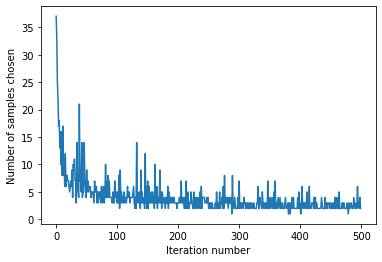

That took 51.27957272529602s


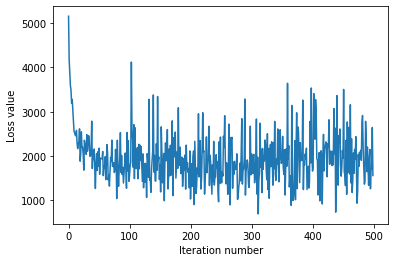

In [ ]:
import time
trial_train = []
trial_test = []

np.random.seed(0)

for i in range(1):
  #svm = MyCLassifier(dims=[2,784])
  svm = MyCLassifier()
  tic = time.time()
  #loss_hist1= svm.train(train_X17, train_y17, option = "loss",learning_rate=1e-5,num_iters=500,threshold = 0,LP_Multi=2, verbose=True, batch_size=100)
  #loss_hist1= svm.train(train_X17, train_y17, option = "distance",learning_rate=1e-3,num_iters=500,threshold = 0,LP_Multi=2, verbose=True, batch_size=100)
  loss_hist1= svm.train(train_X17, train_y17, option = "ILP",learning_rate=1e-3,num_iters=500,threshold = 0,LP_Multi=500, verbose=True, batch_size=100)
  #loss_hist1= svm.train(train_X17, train_y17, option = "LP",learning_rate=1e-5,num_iters=500,threshold = 0,LP_Multi=5, verbose=True, batch_size=100)
  #loss_hist1= svm.train(train_X17, train_y17, option = "random",learning_rate=1e-5,num_iters=500,threshold = 0,LP_Multi=2, verbose=True, batch_size=100)
  toc = time.time()
  print('That took {}s'.format(toc - tic))

  plt.plot(loss_hist1)
  plt.xlabel('Iteration number')
  plt.ylabel('Loss value')
  plt.show()

  y_train_pred = svm.f(train_X17)
  result = 0
  for i in range(len(y_train_pred)):
    if y_train_pred[i] == train_y17.astype('int')[i]:
      result += 1

  trial_train.append(result/y_train_pred.shape[0])
  if train_X17.shape[0] != 20000:
    y_pred = svm.f(test_X17)
    trial_test.append(np.sum(y_pred==test_y17)/y_pred.shape[0])

In [ ]:
# Sample Selection(loss) - with mnist
sample_train = trial_train
sample_test = trial_test
print(sample_train)
print(np.mean(sample_train))
print(np.mean(sample_test))


[0.9896968161472849]
0.9896968161472849
0.9747162022703818


In [ ]:
# Sample Selection(Distance) - with mnist
sample_train = trial_train
sample_test = trial_test
print(sample_train)
print(np.mean(sample_train))
print(np.mean(sample_test))


[0.9840385102609577]
0.9840385102609577
0.9829721362229102


In [ ]:
# ILP - with mnist
sample_train = trial_train
sample_test = trial_test
print(sample_train)
print(np.mean(sample_train))
print(np.mean(sample_test))


[0.9896968161472849]
0.9896968161472849
0.9747162022703818


In [ ]:
# LP - with mnist
sample_train = trial_train
sample_test = trial_test
print(sample_train)
print(np.mean(sample_train))
print(np.mean(sample_test))


[0.8190186639641922]
0.8190186639641922
0.8142414860681114


In [ ]:
# random 100 - w mnist
rand100_train = trial_train
rand100_test = trial_test
print(rand100_train)
print(np.mean(rand100_train))
print(np.mean(rand100_test))

[0.819694282577485]
0.819694282577485
0.8147574819401445


## Synthetic Data with Classifier

In [ ]:
train_X17, train_y17 = create_synthetic(num_points = 10000)
test_X17, test_y17 = create_synthetic(num_points = 2000)
mean_data = np.mean(train_X17, axis=0)
train_X17 -= mean_data
mean_data = np.mean(test_X17, axis=0)
test_X17 -= mean_data

iteration 0 / 1000: loss 3.6908671115716047
iteration 100 / 1000: loss 3.3836185666175624
iteration 200 / 1000: loss 3.04388052624729
iteration 300 / 1000: loss 2.451498781150845
iteration 400 / 1000: loss 2.278293530504814
iteration 500 / 1000: loss 1.7220397191467842
iteration 600 / 1000: loss 1.432468060433705
iteration 700 / 1000: loss 1.0142207142902468
iteration 800 / 1000: loss 0.7233618825639994
iteration 900 / 1000: loss 0.5353673378734489
That took 2.2343387603759766s


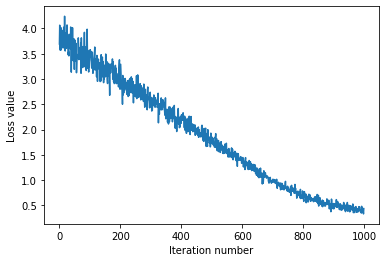

In [ ]:
import time
trial_train = []
trial_test = []

np.random.seed(0)

for i in range(1):
  svm = MyCLassifier()
  tic = time.time()
  #loss_hist1= svm.train(train_X17, train_y17, option = "loss",learning_rate=1e-3,num_iters=1000,threshold = 0,LP_Multi=2, verbose=True, batch_size=100)
  #loss_hist1= svm.train(train_X17, train_y17, option = "distance",learning_rate=1e-3,num_iters=2000,threshold = 0,LP_Multi=2, verbose=True, batch_size=100)
  loss_hist1= svm.train(train_X17, train_y17, option = "random",learning_rate=1e-3,num_iters=1000,threshold = 0,LP_Multi=2, verbose=True, batch_size=100)
  toc = time.time()
  print('That took {}s'.format(toc - tic))

  plt.plot(loss_hist1)
  plt.xlabel('Iteration number')
  plt.ylabel('Loss value')
  plt.show()

  y_train_pred = svm.f(train_X17)
  result = 0
  for i in range(len(y_train_pred)):
    if y_train_pred[i] == train_y17.astype('int')[i]:
      result += 1

  trial_train.append(result/y_train_pred.shape[0])
  y_pred = svm.f(test_X17)
  trial_test.append(np.sum(y_pred==test_y17)/y_pred.shape[0])

In [ ]:
# sample selection(Loss) with synthetic
sample_train = trial_train
sample_test = trial_test
print(sample_train)
print(np.mean(sample_train))
print(np.mean(sample_test))

[0.9175]
0.9175
0.92575


In [ ]:
# sample selection(Dist) with synthetic
sample_train = trial_train
sample_test = trial_test
print(sample_train)
print(np.mean(sample_train))
print(np.mean(sample_test))

[0.9123]
0.9123
0.91875


In [ ]:
# random synthetic
rand100_train = trial_train
rand100_test = trial_test
print(rand100_train)
print(np.mean(rand100_train))
print(np.mean(rand100_test))

[0.8593]
0.8593
0.863


# ILP and LP results with Synthetic Data

iteration 0 / 500: loss 0.8511404316061564
iteration 100 / 500: loss 0.7533213927670807
iteration 200 / 500: loss 0.7072429456054858
iteration 300 / 500: loss 0.659766542464017
iteration 400 / 500: loss 0.6286714462246208


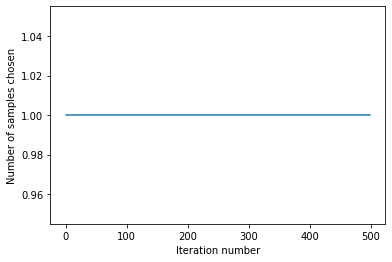

In [ ]:
# LP with Synthetic
np.random.seed()
svm = MyCLassifier()
loss_hist1= svm.train(train_X17, train_y17, option = "ILP",learning_rate=1e-3,num_iters=500,threshold = 0,LP_Multi=1, verbose=True, batch_size=100)#int(train_X17.shape[0]*0.3))

In [ ]:
y_train_pred = svm.f(train_X17)
train_acc = np.sum(train_y17 == y_train_pred)/train_y17.shape[0]
y_test_pred = svm.f(test_X17)
test_acc = np.sum(test_y17 == y_test_pred)/test_y17.shape[0]
#print(np.mean(train_acc))
print(np.mean(test_acc))

0.922


In [ ]:
# ILP with Synthetic
np.random.seed()
svm = MyCLassifier()
loss_hist1= svm.train(train_X17, train_y17, option = "ILP",learning_rate=1e-3,num_iters=500,threshold = 0,LP_Multi=3, verbose=True, batch_size=100)#int(train_X17.shape[0]*0.3))

iteration 0 / 500: loss 4.330148757531804
iteration 100 / 500: loss 2.9545807048196266


In [ ]:
y_train_pred = svm.f(train_X17)
train_acc = np.sum(train_y17 == y_train_pred)/train_y17.shape[0]
y_test_pred = svm.f(test_X17)
test_acc = np.sum(test_y17 == y_test_pred)/test_y17.shape[0]
#print(np.mean(train_acc))
print(np.mean(test_acc))

0.882


iteration 0 / 500: loss 0.6996153100659777
iteration 100 / 500: loss 0.6954290943204657
iteration 200 / 500: loss 0.695851392545093
iteration 300 / 500: loss 0.6969526181176748
iteration 400 / 500: loss 0.6983435996686604


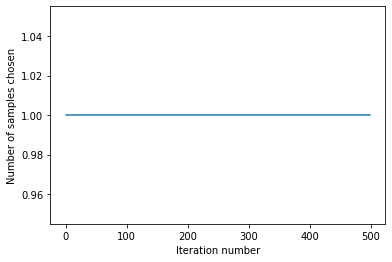

In [ ]:
test_vec = []
for i in range(10):
  np.random.seed()
  svm = MyCLassifier()
  loss_hist1= svm.train(train_X17, train_y17, option = "ILP",learning_rate=1e-3,num_iters=500,threshold = 0,LP_Multi=3, verbose=True, batch_size=100)#int(train_X17.shape[0]*0.3))
  y_test_pred = svm.f(test_X17)
  test_acc = np.sum(test_y17 == y_test_pred)/test_y17.shape[0]
  test_vec.append(test_acc)
  print(np.mean(test_acc))
print(np.mean(test_vec))